In [36]:
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [37]:
files = 'gs://hm-eu-w4/jigsaw/s*/*/params*.csv'
l_files = tf.io.gfile.glob(files)

print(len(l_files))
l_files

40


['gs://hm-eu-w4/jigsaw/s06/20200512_071702_t8b/params0.953930.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_071944_t8c/params0.961078.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_081548_t8b/params0.959556.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_093752_t8c/params0.958322.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_102018_t8b/params0.959827.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_114608_t8c/params0.959633.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_125203_t8b/params0.959691.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_132042_t8d/params0.958907.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_150932_t8c/params0.954059.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_153152_t8d/params0.959152.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_155702_t8b/params0.956271.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_162123_t8c/params0.958224.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_173316_t8d/params0.959693.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_182532_t8b/params0.959394.csv',
 'gs://hm-eu-w4/jigsaw/s06/20200512_193447_t8d/p

In [38]:
# pd.read_csv('gs://hm-eu-w4/jigsaw/t12/20200429_202612_t8c/params0.962192.csv').T[0]

In [39]:
df = None

for f in sorted(tf.io.gfile.glob(files)):
    score = float(os.path.basename(f)[6:-4])
    if score > 0.94:
        if df is None:
            df = pd.read_csv(f)
        else:
            df = df.append(pd.read_csv(f), ignore_index=True)

df.describe()

,auc,batch_size,div_factor,dropout,epochs,final_div_factor,gamma,label_smoothing,lr,max_len,mom_max,mom_min,pos_weight,seed,warm_up,weight_decay
count,40.000000,40.0,40.000000,40.000000,40.000000,40.000000,22.000000,40.000000,40.000000,40.0,40.000000,40.000000,22.000000,40.000000,40.000000,4.000000e+01
mean,0.958424,24.0,264.736524,0.218750,37.075000,1821.090593,1.549213,0.022730,0.000042,192.0,0.945231,0.855911,3.814523,472.450000,3.108440,7.734183e-06
std,0.002455,0.0,242.220035,0.110179,4.648614,2562.634001,0.615320,0.014143,0.000027,0.0,0.024521,0.034178,1.248609,261.958399,1.103488,1.707438e-05
min,0.951417,24.0,19.734814,0.050000,30.000000,10.199568,0.453873,0.002829,0.000010,192.0,0.907151,0.803700,1.530289,51.000000,1.163510,1.046308e-07
25%,0.957818,24.0,75.344061,0.150000,34.500000,50.855812,1.030699,0.009736,0.000019,192.0,0.923439,0.826599,2.683056,224.000000,2.372801,3.640672e-07
50%,0.959324,24.0,158.209867,0.200000,37.000000,662.267250,1.601021,0.018734,0.000038,192.0,0.953149,0.850314,3.949665,476.000000,3.540425,1.342997e-06
75%,0.959791,24.0,390.677391,0.300000,39.000000,2297.931590,2.016995,0.035177,0.000063,192.0,0.966864,0.879016,4.397823,672.250000,3.832784,6.962542e-06
max,0.962582,24.0,816.396833,0.450000,48.000000,8899.934880,2.435291,0.049567,0.000099,192.0,0.979599,0.919152,5.959696,962.000000,4.944110,9.611040e-05


In [40]:
# df.groupby('loss').loss.count().to_frame('loss')
df.pooling.fillna('first', inplace=True)
df.groupby('pooling').auc.describe()

,count,mean,std,min,25%,50%,75%,max
pooling,,,,,,,,
GeM,11.0,0.958162,0.003490,0.951417,0.956963,0.959253,0.960469,0.961557
first,13.0,0.959167,0.001900,0.954059,0.958648,0.959632,0.959779,0.962582
max,16.0,0.957999,0.001984,0.953930,0.956338,0.959048,0.959531,0.960095


In [41]:
# df.drop(['max_len', 'gcs',
#          'path', 'tpu_id', 'seed', 'dataset'], #'model_id', 'stages', 'amp', , 'callback', 'kwargs'
#               inplace=True, axis=1)
df.sort_values(by='auc', ascending=False)

,auc,batch_size,dataset,div_factor,dropout,dual,epochs,final_div_factor,gamma,gcs,...,mom_max,mom_min,optimizer,path,pooling,pos_weight,seed,tpu_id,warm_up,weight_decay
38,0.962582,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds7-...,74.138260,0.25,False,40,2269.157070,0.990529,hm-eu-w4,...,0.934460,0.836987,LAMB,jigsaw/s07,first,2.165151,178,t8b,3.539545,6.719302e-06
36,0.961557,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds7-...,204.755795,0.05,False,39,7487.892232,NaN,hm-eu-w4,...,0.962060,0.893677,AdamW,jigsaw/s07,GeM,NaN,359,t8b,3.579122,1.452406e-07
1,0.961078,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds6-...,816.396833,0.15,False,35,42.548445,NaN,hm-eu-w4,...,0.907737,0.830961,LAMB,jigsaw/s06,GeM,NaN,394,t8c,3.600752,4.343691e-06
17,0.960660,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds6-...,34.692448,0.25,False,37,93.491673,2.435291,hm-eu-w4,...,0.907352,0.845019,AdamW,jigsaw/s06,GeM,4.208485,907,t8b,1.197686,2.912438e-06
14,0.960449,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds6-...,75.745995,0.40,False,35,2557.529677,NaN,hm-eu-w4,...,0.974364,0.821402,LAMB,jigsaw/s06,first,NaN,384,t8d,4.235828,1.328109e-07
39,0.960277,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds7-...,566.387785,0.15,False,39,7472.504347,NaN,hm-eu-w4,...,0.958506,0.889714,AdamW,jigsaw/s07,GeM,NaN,577,t8b,4.263668,4.640115e-06
15,0.960184,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds6-...,225.264542,0.20,False,31,973.366065,2.355027,hm-eu-w4,...,0.927758,0.824704,AdamW,jigsaw/s06,GeM,3.490155,669,t8b,3.892442,2.196048e-06
24,0.960095,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds6-...,107.513337,0.20,False,36,413.232052,NaN,hm-eu-w4,...,0.908807,0.870949,LAMB,jigsaw/s06,max,NaN,851,t8b,1.163510,4.070324e-06
22,0.959964,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds6-...,382.317034,0.35,False,36,16.985098,2.298552,hm-eu-w4,...,0.955343,0.862229,LAMB,jigsaw/s06,first,4.230386,523,t8d,2.363692,7.858322e-06
4,0.959827,24,gs://hm-eu-w4/jigsaw/translated-distilled-ds6-...,750.969253,0.20,False,38,6671.881958,1.802636,hm-eu-w4,...,0.955301,0.803700,LAMB,jigsaw/s06,max,4.065089,557,t8b,3.778089,1.439624e-06


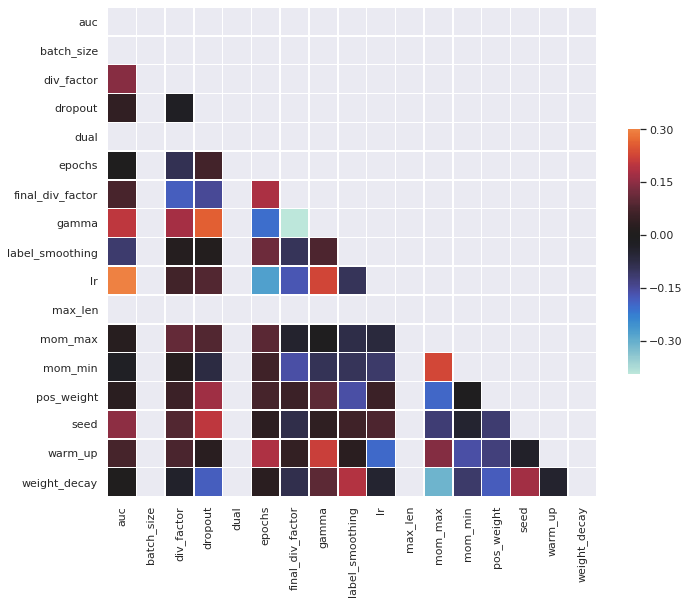

In [42]:
# Compute the correlation matrix
corr = df.corr('kendall')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, vmax=.3, center=0, # cmap=cmap,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [43]:
candidates = sorted(tf.io.gfile.glob(files))
files, preds, oof, scores = [], [], [], []

for f in candidates:
    score = float(os.path.basename(f)[6:-4])
    if score < 0.954:
        continue
    folder = os.path.dirname(f)
    sub_path = os.path.join(folder, 'submission.csv')
    sub = pd.read_csv(sub_path)
    print(score, sub.toxic.mean(), (sub.toxic > 0.5).mean(), sub_path)
    if sub.toxic.mean() < 0.49:
        files.append(f)
        scores.append(score)

        sub.to_csv(f'../submission_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)
        preds.append(sub.toxic.values)

        valid = pd.read_csv(os.path.join(folder, 'valid_oof.csv'))
        valid.to_csv(f'../valid_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)
        oof.append(valid.pred.values)
        assert abs(roc_auc_score(valid.toxic, valid.pred) - score) < 1e-5

        params = pd.read_csv(f)
        params.to_csv(f'../params_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)
    
!ls -sh *.csv

0.961078 0.24147765587955242 0.20815834012411458 gs://hm-eu-w4/jigsaw/s06/20200512_071944_t8c/submission.csv
0.959556 0.6780208377917947 0.8344041873001943 gs://hm-eu-w4/jigsaw/s06/20200512_081548_t8b/submission.csv
0.958322 0.4317019337588541 0.38290603648216637 gs://hm-eu-w4/jigsaw/s06/20200512_093752_t8c/submission.csv
0.959827 0.3506151982580079 0.23887356610042 gs://hm-eu-w4/jigsaw/s06/20200512_102018_t8b/submission.csv
0.959633 0.4689765657813577 0.3948943772331223 gs://hm-eu-w4/jigsaw/s06/20200512_114608_t8c/submission.csv
0.959691 0.1453521819450605 0.11142104933241397 gs://hm-eu-w4/jigsaw/s06/20200512_125203_t8b/submission.csv
0.958907 0.36612529148904593 0.3008368331975177 gs://hm-eu-w4/jigsaw/s06/20200512_132042_t8d/submission.csv
0.954059 0.40113110280668207 0.27236256503478967 gs://hm-eu-w4/jigsaw/s06/20200512_150932_t8c/submission.csv
0.959152 0.15723470177900709 0.11662383250799223 gs://hm-eu-w4/jigsaw/s06/20200512_153152_t8d/submission.csv
0.956271 0.8203900035327211 1.

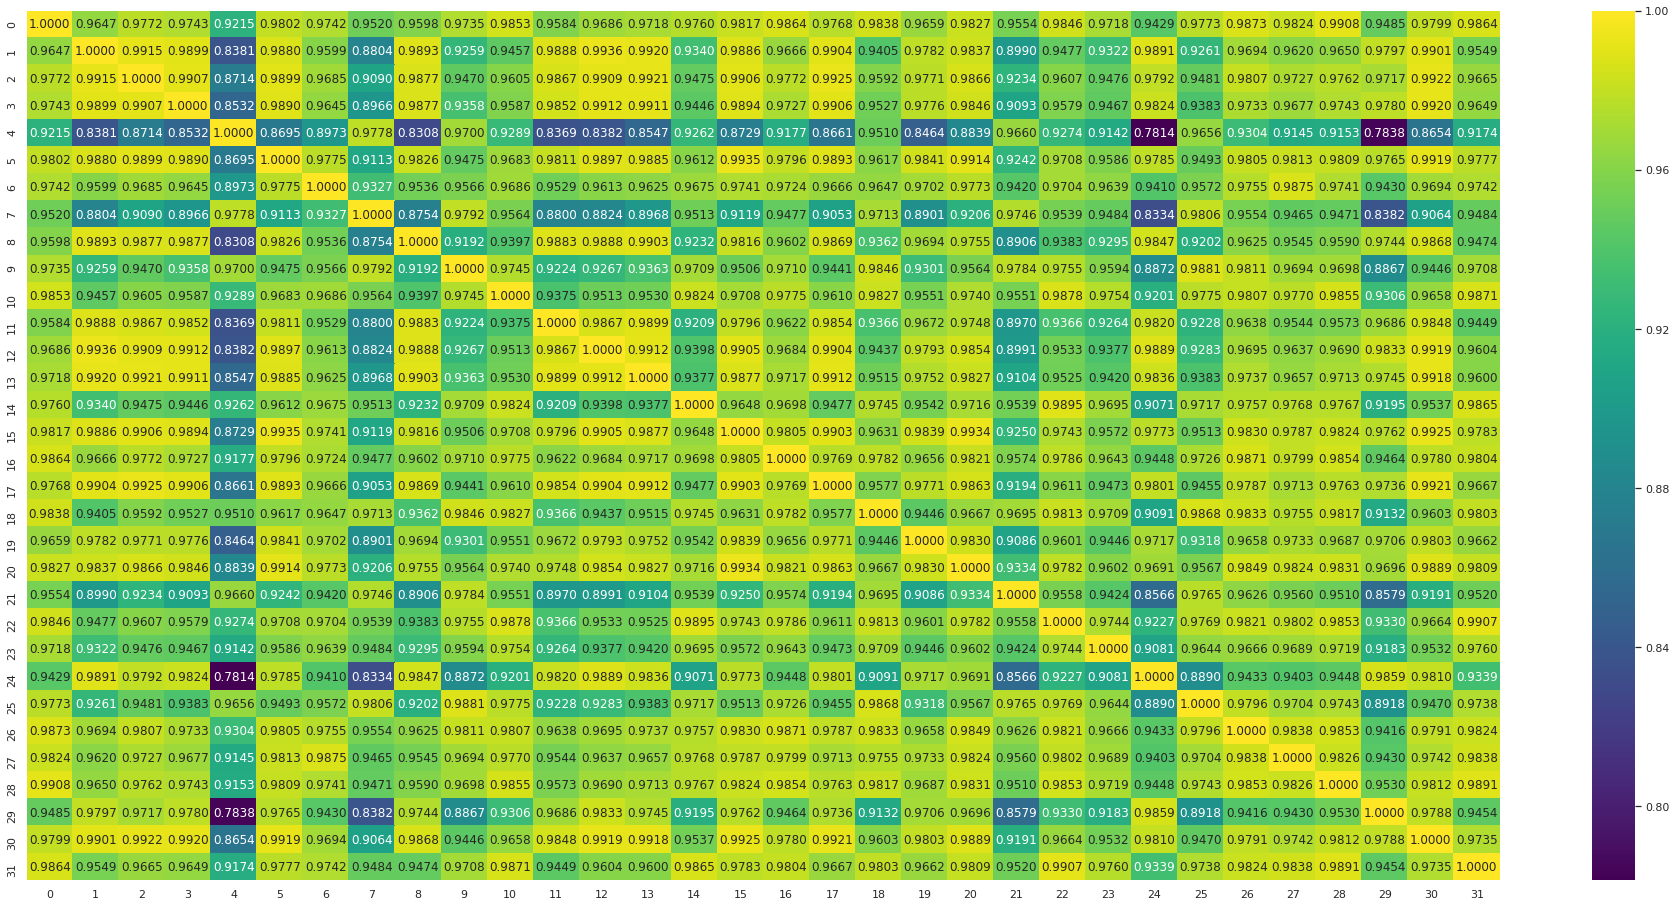

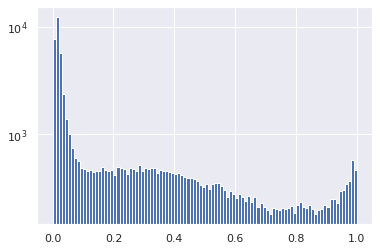

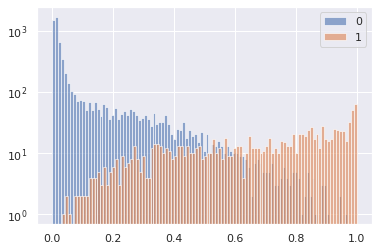

AUC: 0.9607725378583181 toxic: 0.15375 pred: 0.19080999718838534 ratio: 0.146875
mean score: 0.9591935312500001


{'gs://hm-eu-w4/jigsaw/s06/20200512_071944_t8c/params0.961078.csv': 0.021015043778827458,
 'gs://hm-eu-w4/jigsaw/s06/20200512_093752_t8c/params0.958322.csv': 0.030044330653418144,
 'gs://hm-eu-w4/jigsaw/s06/20200512_102018_t8b/params0.959827.csv': 0.023628532212254905,
 'gs://hm-eu-w4/jigsaw/s06/20200512_114608_t8c/params0.959633.csv': 0.02621023224231509,
 'gs://hm-eu-w4/jigsaw/s06/20200512_125203_t8b/params0.959691.csv': 0.08058130013375113,
 'gs://hm-eu-w4/jigsaw/s06/20200512_132042_t8d/params0.958907.csv': 0.021683941281237705,
 'gs://hm-eu-w4/jigsaw/s06/20200512_150932_t8c/params0.954059.csv': 0.028223363706579487,
 'gs://hm-eu-w4/jigsaw/s06/20200512_153152_t8d/params0.959152.csv': 0.055988626943954595,
 'gs://hm-eu-w4/jigsaw/s06/20200512_173316_t8d/params0.959693.csv': 0.03412843927397206,
 'gs://hm-eu-w4/jigsaw/s06/20200512_182532_t8b/params0.959394.csv': 0.0351093180199194,
 'gs://hm-eu-w4/jigsaw/s06/20200512_193447_t8d/params0.960449.csv': 0.026939453077610396,
 'gs://hm-eu-w4

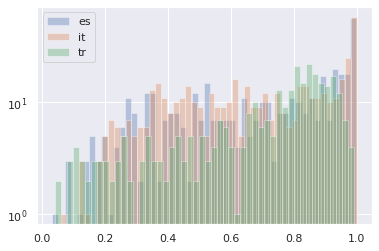

In [44]:
corr_mat = np.corrcoef(preds)
# print(corr_mat)

weights = (1-corr_mat).sum(axis=0) # gain
weights /= weights.sum()

fig, ax = plt.subplots(figsize=(len(preds)+1, len(preds)//2))
ax = sns.heatmap(corr_mat, cmap='viridis', annot=True, fmt="0.04f", ax=ax)
plt.show()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
sub.toxic -= sub.toxic.min()
sub.toxic /= sub.toxic.max()
valid['pred'] = np.average(oof, weights=weights, axis=0)
valid.pred -= valid.pred.min()
valid.pred /= valid.pred.max()

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_decorr{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_decorr{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

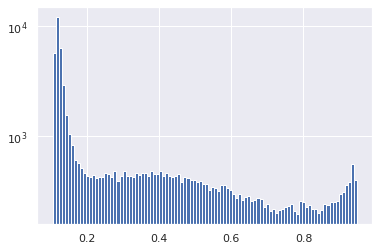

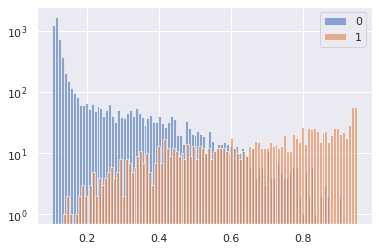

AUC: 0.9608921473262 toxic: 0.15375 pred: 0.27156413285287945 ratio: 0.16725
mean score: 0.9591935312500001


{'gs://hm-eu-w4/jigsaw/s06/20200512_071944_t8c/params0.961078.csv': 0.03271170037593131,
 'gs://hm-eu-w4/jigsaw/s06/20200512_093752_t8c/params0.958322.csv': 0.030548606027928384,
 'gs://hm-eu-w4/jigsaw/s06/20200512_102018_t8b/params0.959827.csv': 0.031693047619844136,
 'gs://hm-eu-w4/jigsaw/s06/20200512_114608_t8c/params0.959633.csv': 0.03154073381801961,
 'gs://hm-eu-w4/jigsaw/s06/20200512_125203_t8b/params0.959691.csv': 0.031586117294698395,
 'gs://hm-eu-w4/jigsaw/s06/20200512_132042_t8d/params0.958907.csv': 0.030983496021998822,
 'gs://hm-eu-w4/jigsaw/s06/20200512_150932_t8c/params0.954059.csv': 0.02771391136527282,
 'gs://hm-eu-w4/jigsaw/s06/20200512_153152_t8d/params0.959152.csv': 0.031169330249510355,
 'gs://hm-eu-w4/jigsaw/s06/20200512_173316_t8d/params0.959693.csv': 0.03158768457171209,
 'gs://hm-eu-w4/jigsaw/s06/20200512_182532_t8b/params0.959394.csv': 0.031355090430773724,
 'gs://hm-eu-w4/jigsaw/s06/20200512_193447_t8d/params0.960449.csv': 0.032191469293620864,
 'gs://hm-eu-w

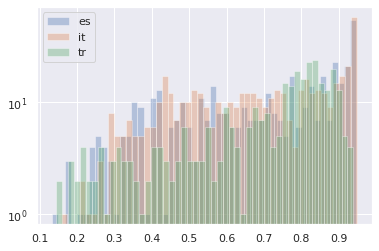

In [45]:
# weight by score
weights = 1 / (1-np.array(scores))
weights /= weights.sum()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
valid['pred'] = np.average(oof, weights=weights, axis=0)

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_score_blend{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_score_blend{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

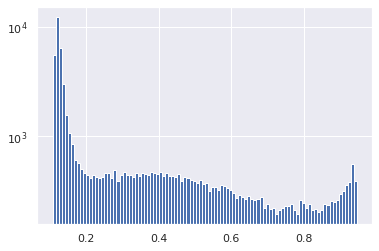

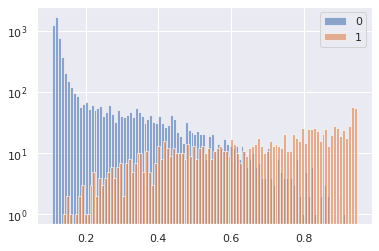

AUC: 0.9608544391204621 toxic: 0.15375 pred: 0.27439538343634856 ratio: 0.167875
mean score: 0.9591935312500001


{'gs://hm-eu-w4/jigsaw/s06/20200512_071944_t8c/params0.961078.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_093752_t8c/params0.958322.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_102018_t8b/params0.959827.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_114608_t8c/params0.959633.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_125203_t8b/params0.959691.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_132042_t8d/params0.958907.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_150932_t8c/params0.954059.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_153152_t8d/params0.959152.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_173316_t8d/params0.959693.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_182532_t8b/params0.959394.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_193447_t8d/params0.960449.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_211728_t8b/params0.960184.csv': 0.03125,
 'gs://hm-eu-w4/jigsaw/s06/20200512_214443_t8c/params0.959632.csv': 0.03125,

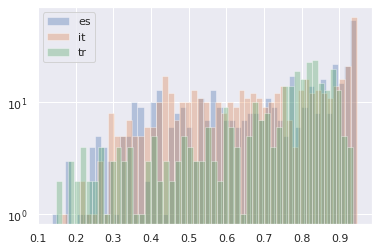

In [46]:
# average
weights = np.ones_like(scores)
weights /= weights.sum()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
valid['pred'] = np.average(oof, weights=weights, axis=0)

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_avg{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_avg{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

shapes: (8000, 33) (8000,)
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         1.3430e+05                                    2.71e+04    
       1         3.2207e+04      1.02e+05       1.52e+00       6.78e+03    
       2         7.5209e+03      2.47e+04       7.57e-01       1.69e+03    
       3         1.7633e+03      5.76e+03       3.76e-01       4.23e+02    
       4         5.2222e+02      1.24e+03       1.84e-01       1.06e+02    
       5         2.9439e+02      2.28e+02       8.43e-02       2.63e+01    
       6         2.4893e+02      4.55e+01       6.17e-02       4.16e+01    
       7         2.3454e+02      1.44e+01       1.83e-01       6.68e+00    
       8         2.2387e+02      1.07e+01       5.10e-02       6.64e+00    
       9         2.2030e+02      3.56e+00       1.41e-01       2.30e+00    
      10         2.1839e+02      1.91e+00       3.08e-02       7.92e-01    
      11         2.1755e+02      8.45e-01       9.41e-02     

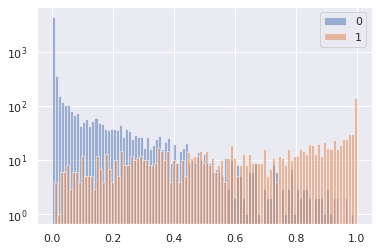

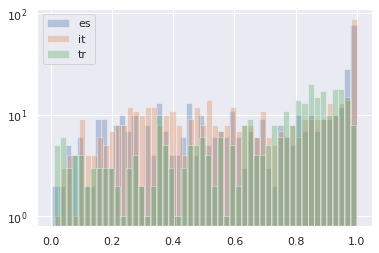

AUC: 0.9616509949442182 toxic: 0.15375 pred: 0.15473050178621622 ratio: 0.122375
mean score: 0.9591935312500001
top score: 0.961557 28 0.9615567244298735
0.27519443259475745
0


{'gs://hm-eu-w4/jigsaw/s06/20200512_071944_t8c/params0.961078.csv': 0.004408950501613676,
 'gs://hm-eu-w4/jigsaw/s06/20200512_093752_t8c/params0.958322.csv': 5.183930087126288e-36,
 'gs://hm-eu-w4/jigsaw/s06/20200512_102018_t8b/params0.959827.csv': 1.9654265545748647e-35,
 'gs://hm-eu-w4/jigsaw/s06/20200512_114608_t8c/params0.959633.csv': 3.2443644082695135e-36,
 'gs://hm-eu-w4/jigsaw/s06/20200512_125203_t8b/params0.959691.csv': 0.2562156673401371,
 'gs://hm-eu-w4/jigsaw/s06/20200512_132042_t8d/params0.958907.csv': 5.254459748175625e-36,
 'gs://hm-eu-w4/jigsaw/s06/20200512_150932_t8c/params0.954059.csv': 1.2930437859045163e-35,
 'gs://hm-eu-w4/jigsaw/s06/20200512_153152_t8d/params0.959152.csv': 0.06244645313838945,
 'gs://hm-eu-w4/jigsaw/s06/20200512_173316_t8d/params0.959693.csv': 9.545014128676975e-36,
 'gs://hm-eu-w4/jigsaw/s06/20200512_182532_t8b/params0.959394.csv': 9.046604523928325e-35,
 'gs://hm-eu-w4/jigsaw/s06/20200512_193447_t8d/params0.960449.csv': 0.24352316368348417,
 'gs

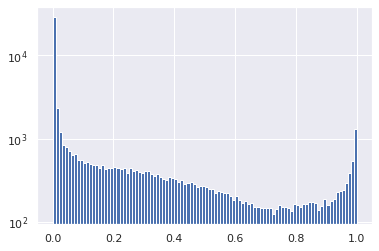

In [47]:
from scipy.optimize import lsq_linear

bias = np.ones_like(oof[0]).tolist()
A = np.stack(oof + [bias]).T.copy()
# A = np.stack(oof).T.copy()
b = valid.toxic.values.copy()
print('shapes:', A.shape, b.shape)

res = lsq_linear(A, b, bounds=(0, 1), lsq_solver='exact', method='trf', tol=1e-15, verbose=2)
print(res)
best_weights = res.x
valid_preds = A.dot(best_weights)
print('MSE:', mean_squared_error(b, valid_preds))
print('AUC:', roc_auc_score(b, valid_preds))
print('Sum of weights:', sum(best_weights))

valid['pred'] = valid_preds
valid.pred -= valid.pred.min()
valid.pred /= valid.pred.max()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
plt.legend(valid.lang.unique())
plt.show()

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))
top = np.argmax(best_weights[:len(preds)])
print('top score:', scores[top], top, roc_auc_score(valid.toxic, oof[top]))

sub['toxic'] = np.stack(preds).T.dot(best_weights[:len(preds)])
sub.toxic -= sub.toxic.min()
sub.toxic /= sub.toxic.max()
ax = sub.toxic.hist(bins=100, log=True)
sub.to_csv(f'../submission_lsq{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_lsq{len(preds)}_{valid_auc:.04f}.csv', index=False)

bias = np.ones_like(oof[0]).tolist()
print(abs(A - np.stack(oof + [bias]).T.copy()).max())
# print(abs(A - np.stack(oof).T.copy()).mean())
print(abs(b - valid.toxic.values.copy()).max())

{f:w for f,w in zip(files, best_weights[:len(preds)])}

# Remove low scoring and incomplete models 

In [48]:
# # clean up
# folders = 'gs://hm-eu-w4/jigsaw/*/*/*'
# for f in tf.io.gfile.glob(folders):
#     n_items = len(tf.io.gfile.glob(os.path.join(f, 'best_model.tf*')))
#     print(f, n_items, len(tf.io.gfile.glob(os.path.join(f, '*'))))
#     if n_items > 0:
#         params = tf.io.gfile.glob(os.path.join(f, 'params*.csv'))
#         if len(params) == 0:
#             print(f, n_items, tf.io.gfile.glob(os.path.join(f, '*')))
#             !gsutil -m rm -r {f}
#         else:
#             score = float(os.path.basename(params[0])[6:-4])
#             if score < 0.9575:
#                 !gsutil -m rm -r {f}
# #     elif n_items == 0:
# #         !gsutil rm -r {f}

l.tf.data-00000-of-00002 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/best_model.tf.data-00001-of-00002 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/best_model.tf.index 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/checkpoint 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/history.csv 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/history.png 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/params0.956212.csv 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/sub_hist.png 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/submission.csv 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/valid_hist.png 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/valid_oof.csv 0 0
gs://hm-eu-w4/jigsaw/t05/20200512_093026_t8d/valid_toxic_hist.png 0 0
gs://hm-eu-w4/jigsaw/t12/20200428_233949_t8b/ 3 12
gs://hm-eu-w4/jigsaw/t12/20200428_233949_t8b/best_model.tf.data-00000-of-00002 0 0
gs://hm-eu-w4/jigsaw/t12/20200428_233949_t8b/best_model.tf.data-00001-of-00002 0 0
gs://hm-eu-w4/jigsaw/t12/2020

In [49]:
# import pdb; pdb.pm()